In [1]:
'''
Questo modello carica i pesi del modello precedente (Base) ed effettua un secondo fine-tuning
Il modello verrà poi salvato, ed utilizzato in seguito per fare inferenza
'''

'\nQuesto modello carica i pesi del modello precedente (Base) ed effettua un secondo fine-tuning\nIl modello verrà poi salvato, ed utilizzato in seguito per fare inferenza\n'

In [2]:
# Caricamento libreirie
from fastai.vision.all import *
from fastai.torch_core import set_seed

import os
import pandas as pd
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

In [3]:
SEED = 123
IMG_SIZE = 512
BS = 8


set_seed(SEED, reproducible=True)

In [4]:
# Creazione dataframe
df = pd.read_csv('/kaggle/input/large-debris/inputs.csv')

df.head()

,image,coordinates
0,image_1.png,"[(389.0, 328.0), (301.0, 373.0)]"
1,image_2.png,"[(94.0, 167.0), (43.0, 108.0)]"
2,image_3.png,"[(411.0, 156.0), (286.0, 145.0)]"
3,image_4.png,"[(465.0, 243.0), (384.0, 356.0)]"
4,image_5.png,"[(289.0, 282.0), (91.0, 179.0)]"


In [5]:
# Rimozione validation-set (dopo aver eseguito il training del modello)
df['is_valid'] = False

In [6]:
# Creazione piccolo test-set 

#df_test = df[-10:]

#df = df[:-10]

In [7]:
# Definizione dataloader
imgs_path = '/kaggle/input/large-debris/casted_images/'
msks_path = '/kaggle/input/large-debris/casted_masks_1px/'

codes = ['Background', 'Debris']

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), MaskBlock(codes)), #PointBlock
    get_x=ColReader('image', pref=imgs_path),
    get_y=ColReader('image', pref=msks_path),
    splitter=ColSplitter('is_valid'),
    #splitter=RandomSplitter(valid_pct=0.2, seed=SEED),
    #item_tfms=Resize(IMG_SIZE),
    batch_tfms=[Flip()],
)

dls = dblock.dataloaders(df, bs=BS)
dls.c = dls.train.after_item.c

In [8]:
#dblock.summary(df)
#dls.one_batch()

#print('Mini-batch shape: ', list(dls.one_batch()[0].shape))
#print('Targets shape', list(dls.one_batch()[1].shape))

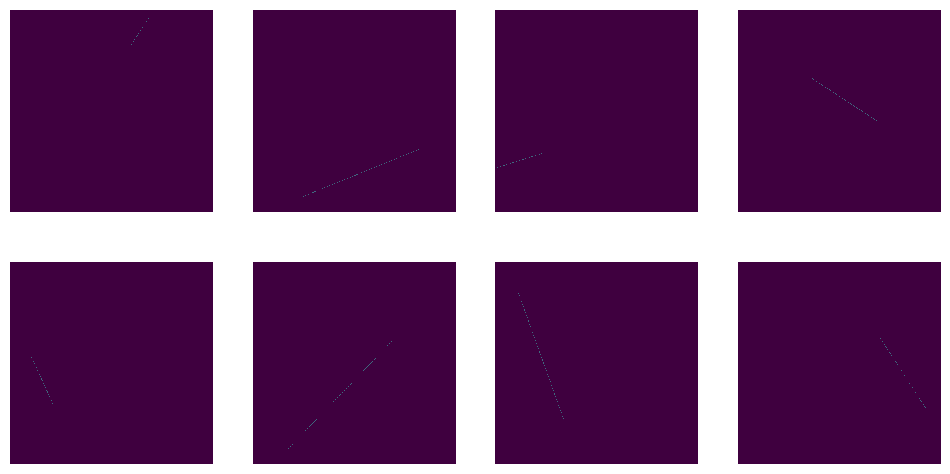

In [9]:
# Visualizzazione dataset
dls.show_batch(cmap='jet', vmin=0, vmax=3)

In [10]:
# Inizializzazione pesi loss-function
wgts = torch.tensor([1, 55]).float().cuda() #Best!!!

In [11]:
# Loss-function che penalizza la frammentazione delle maschere 
def regularization_loss(y_pred):
    # Penalize non-linear sparse masks
    dx = torch.abs(y_pred[:, :, 1:] - y_pred[:, :, :-1])
    dy = torch.abs(y_pred[:, :, :, 1:] - y_pred[:, :, :, :-1])
    reg_loss = torch.mean(dx) + torch.mean(dy)
    return reg_loss

# Loss-function combinata basata su Crossentropy-loss
def combined_loss(y_pred, y_true):
    ce_loss = F.cross_entropy(y_pred, y_true, weight=wgts)
    reg_loss = regularization_loss(y_pred)
    total_loss = ce_loss + reg_loss 
    return total_loss

In [12]:
# Definizione architettura e ulteriori iper-parametri per il training 
learn = unet_learner(
    dls, resnet18, 
    n_in=1,
    n_out=dls.c,
    loss_func=combined_loss,
    opt_func=ranger,
    normalize=False,
    self_attention=True,
).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 119MB/s] 


In [13]:
# Caricamento modello con training "Base", per effettuare secondo fine-tuning
learn.load('/kaggle/input/debris/self_att_unet')

/opt/conda/lib/python3.10/site-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


In [14]:
# Sblocco pesi modello per fine-tuning
learn.unfreeze()

In [15]:
# Tool stimatore del learning rate
#learn.lr_find()

In [16]:
# Training del modello
lr = 1e-3 

learn.fit_flat_cos(6, slice(lr)) # 6 epoche

epoch,train_loss,valid_loss,time
0,0.040494,None,09:15
1,0.031623,None,09:15
2,0.027415,None,09:15
3,0.027027,None,09:15
4,0.025824,None,09:14
5,0.023082,None,09:14


/opt/conda/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [17]:
# Salvataggio del modello

#learn.export('export_large.pkl')
learn.save('final_resnet_inf_large')

Path('models/final_resnet_inf_large.pth')

In [20]:
from IPython.display import FileLink 
FileLink(r'models/final_resnet_inf_large.pth')

/kaggle/working/models/final_resnet_inf_large.pth

In [ ]:
# Visualizzaione dei risultati ottenuti sul validation-set

learn.show_results(cmap='gray')

In [ ]:
# Predizioni sul test-set
test_dl = dls.test_dl(df_test, with_labels=True, shuffle=False)

preds = learn.get_preds(dl=test_dl)

In [ ]:
# Risultati su Test-set
learn.validate(dl=test_dl)